In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from os import listdir

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from scipy.cluster.hierarchy import cut_tree

In [2]:
filepaths = [f for f in listdir("./data") if f.endswith('.csv')]
files = [pd.read_csv('./data/' + f, sep=",", encoding="ISO-8859-1", header=0) for f in filepaths]

In [3]:
cellphones = pd.concat(files)
cellphones.head()

,datetime,CellID,countrycode,smsin,smsout,callin,callout,internet
0,2013-11-02 00:00:00,1,0,0.2445,NaN,NaN,NaN,NaN
1,2013-11-02 00:00:00,1,39,1.4952,1.1213,0.2708,0.3004,46.5094
2,2013-11-02 00:00:00,1,53,0.0018,0.0036,NaN,NaN,NaN
3,2013-11-02 00:00:00,2,0,0.2458,NaN,NaN,NaN,NaN
4,2013-11-02 00:00:00,2,39,1.5028,1.1243,0.2751,0.3023,46.6933


In [4]:
#We Can see that alot of the value is missing so we are going to replace the NAN value with Zero
df_null = round(100*(cellphones.isnull().sum())/len(cellphones), 2)
df_null


datetime        0.00
CellID          0.00
countrycode     0.00
smsin          60.46
smsout         76.68
callin         72.53
callout        57.34
internet       55.18
dtype: float64

In [5]:
cellphones['smsin'] = cellphones['smsin'].fillna(0)
cellphones['smsout'] = cellphones['smsin'].fillna(0)
cellphones['callin'] = cellphones['callin'].fillna(0)
cellphones['callout'] = cellphones['callout'].fillna(0)
cellphones['internet'] = cellphones['internet'].fillna(0)

In [8]:
# Changing the datatype of Customer Id as per Business understanding

cellphones.loc[:,'countrycode'] = cellphones.loc[:,'countrycode'].astype(str)
cellphones.loc[:,'datetime'] = pd.to_datetime(cellphones.loc[:,'datetime'],format='%Y-%m-%d %H:%M:%S')
cellphones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13197237 entries, 0 to 2407383
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   datetime     datetime64[ns]
 1   CellID       object        
 2   countrycode  object        
 3   smsin        float64       
 4   smsout       float64       
 5   callin       float64       
 6   callout      float64       
 7   internet     float64       
 8   Amount       float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 1006.9+ MB


In [12]:
#First we will group the custmers by how much the spent
cellphones.loc[:,'Amount'] = cellphones.loc[:,'smsin']+cellphones.loc[:,'smsout']+cellphones.loc[:,'callin']+cellphones.loc[:,'callout']+cellphones.loc[:,'internet']
country_spending_grouping = cellphones.groupby('countrycode',as_index=False)['Amount'].sum()
country_spending_grouping.head()

,countrycode,Amount
0,0,2.456115e+07
1,1,2.686610e+05
2,1139,6.283100e+00
3,1204,1.135112e+03
4,1214,1.910631e+03


In [13]:
country_spending_grouping.shape

(318, 2)

In [14]:
country_spending_grouping.describe()

,Amount
count,3.180000e+02
mean,2.345708e+06
std,4.015614e+07
min,0.000000e+00
25%,3.769875e+01
50%,2.788619e+02
75%,4.150076e+03
max,7.157602e+08


array([[<AxesSubplot:title={'center':'Amount'}>]], dtype=object)

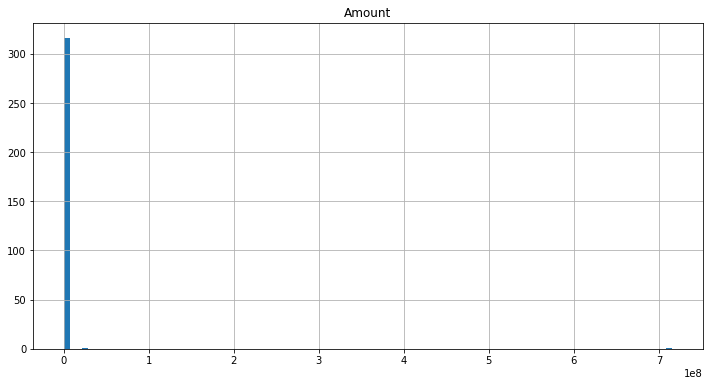

In [15]:
country_spending_grouping.hist(column='Amount', bins=100, figsize=(12,6))

Text(0.5, 0, 'Attributes')

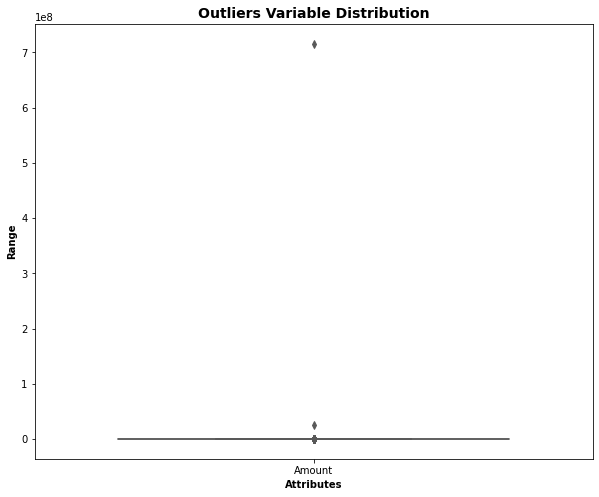

In [16]:
attributes = ['Amount']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = country_spending_grouping[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [17]:
#Removing (statistical) outliers for Amount
Q1 = country_spending_grouping.Amount.quantile(0.25)
Q3 = country_spending_grouping.Amount.quantile(0.75)
IQR = Q3 - Q1
country_spending_grouping = country_spending_grouping[(country_spending_grouping.Amount >= Q1 - 1.5*IQR) & (country_spending_grouping.Amount <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

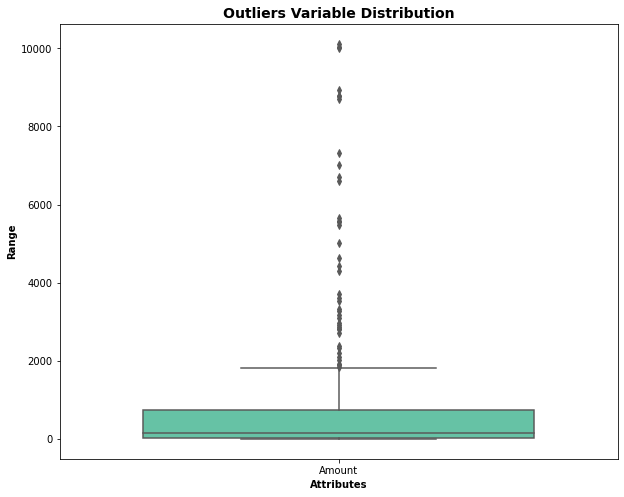

In [18]:
attributes = ['Amount']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = country_spending_grouping[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

array([[<AxesSubplot:title={'center':'Amount'}>]], dtype=object)

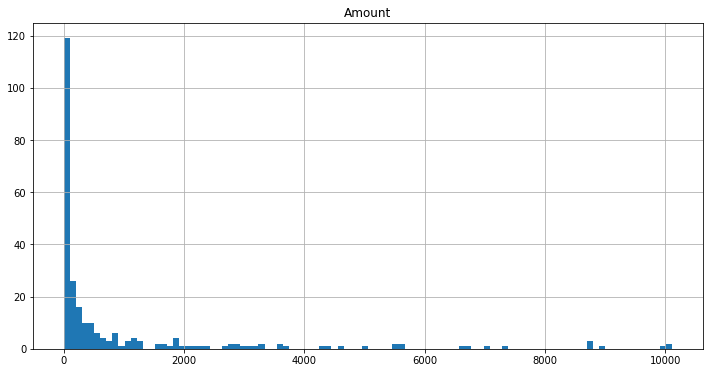

In [21]:
country_spending_grouping.hist(column='Amount', bins=100, figsize=(12,6))

In [22]:
# Rescaling the attributes

country_spending_grouping_df = country_spending_grouping[['Amount']]

# Instantiate
scaler = StandardScaler()

# fit_transform
country_spending_grouping_df_scaled = scaler.fit_transform(country_spending_grouping_df)
country_spending_grouping_df_scaled.shape

(257, 1)

In [24]:
country_spending_grouping_df_scaled = pd.DataFrame(country_spending_grouping_df_scaled)
country_spending_grouping_df_scaled.columns = ['Amount']
country_spending_grouping_df_scaled.head()

,Amount
0,-0.486885
1,0.089051
2,0.484725
3,-0.475665
4,-0.448019


array([[<AxesSubplot:title={'center':'Amount'}>]], dtype=object)

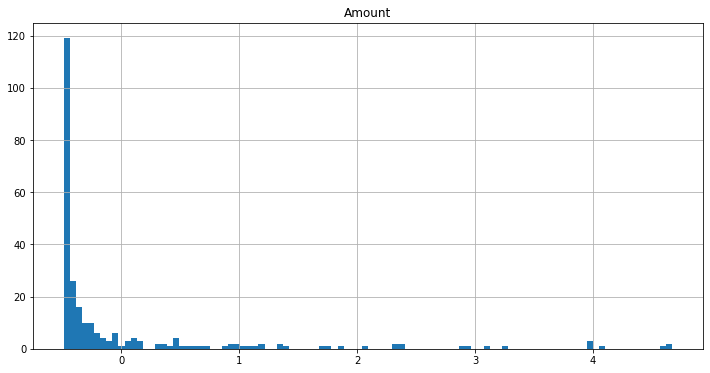

In [25]:
country_spending_grouping_df_scaled.hist(column='Amount', bins=100, figsize=(12,6))

In [26]:
country_spending_grouping_df_scaled.describe()

,Amount
count,2.570000e+02
mean,2.764758e-17
std,1.001951e+00
min,-4.900905e-01
25%,-4.772676e-01
50%,-4.175993e-01
75%,-1.066443e-01
max,4.672508e+00


In [28]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(country_spending_grouping_df_scaled)

KMeans(max_iter=50, n_clusters=4)

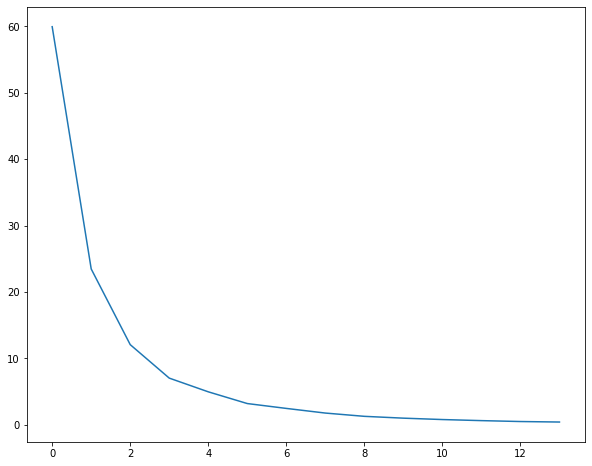

In [29]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_spending_grouping_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [30]:
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_spending_grouping_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(country_spending_grouping_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.8490724944442275
For n_clusters=3, the silhouette score is 0.8081640137768304
For n_clusters=4, the silhouette score is 0.8075345948667598
For n_clusters=5, the silhouette score is 0.7619864717372976
For n_clusters=6, the silhouette score is 0.7638591011317245
For n_clusters=7, the silhouette score is 0.7348819175161038
For n_clusters=8, the silhouette score is 0.7438299608770144
For n_clusters=9, the silhouette score is 0.702604859637757
For n_clusters=10, the silhouette score is 0.7017498303917926
For n_clusters=11, the silhouette score is 0.6937997580347444
For n_clusters=12, the silhouette score is 0.6773013897033029
For n_clusters=13, the silhouette score is 0.6890153079339911
For n_clusters=14, the silhouette score is 0.6755083259513421
For n_clusters=15, the silhouette score is 0.6770868091147983


In [31]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(country_spending_grouping_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [32]:
kmeans.labels_

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 0, 3, 1, 3, 1, 0, 1, 1, 0, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 3, 1, 1, 1, 0, 2, 1,
       0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1])

In [33]:
# assign the label
country_spending_grouping['Cluster_Id'] = kmeans.labels_
country_spending_grouping.head()

,countrycode,Amount,Cluster_Id
2,1139,6.2831,1
3,1204,1135.1117,1
4,1214,1910.6308,0
5,1226,28.2741,1
6,1242,82.4596,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

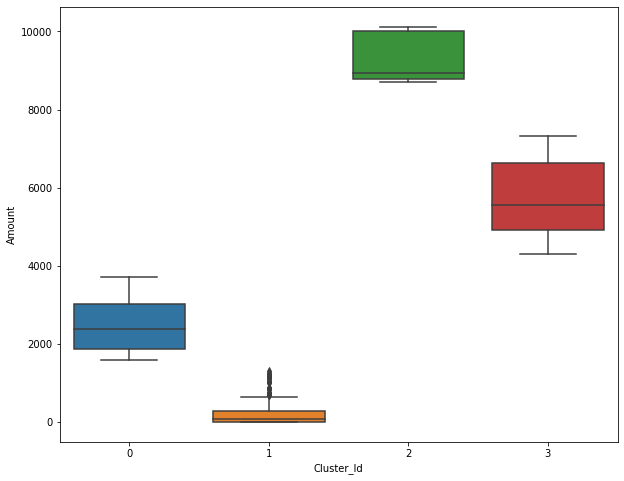

In [34]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=country_spending_grouping)